In [1]:
#import required packages
import numpy as np
import os
import sys
import inspect
import matplotlib.pyplot as plt
import time 

#Define WPIT package location
current_dir =  os.path.abspath(os.path.dirname('__file__'))
fpath = os.path.abspath(current_dir + "/..")
#add WPIT path to Python path
sys.path.append(fpath)

#import WPIT modules
import WPIT.Environment_mod as env
import WPIT.WaveProperties_mod as wave
import WPIT.WPI_mod.whistler_electron_mod as wpi

### 1. Define simulation parameters

Here we define all the initial parameters of the simulation in respect with the particle and the wave, To recreate the plots of WPIT publication, vary these parameters according to:

---

**A. Wave amplitude dependence**

*  <font color='red'>By_wave={10x10^(-12), 35x10^(-12), 65x10^(-12), 100x10^(-12)}</font>   

* ne_0=10*10^6
* L_shell=5
* aeq0_deg=68   
* Ekev0=168.3 
* lamda0_deg=-9  
* theta0_deg=0.0001
* f_wave=2000 
* m_res=1 
* eta0_deg=np.linspace(0,360,120) 

---

**B. Equatorial pitch angle dependence**

*  <font color='red'>aeq0_deg={62, 63, 65, 71} </font>   

* By_wave=65x10^(-12)
* ne_0=10*10^6
* L_shell=5
* Ekev0=168.3 
* lamda0_deg=-9  
* theta0_deg=0.0001
* f_wave=2000 
* m_res=1 
* eta0_deg=np.linspace(0,360,120) 

---

**C. Energy dependence**

*  <font color='red'>Ekev0={90, 140, 200, 270} </font>   

* By_wave=65x10^(-12)
* ne_0=10*10^6
* L_shell=5
* aeq0_deg=68   
* lamda0_deg=-9  
* theta0_deg=0.0001
* f_wave=2000 
* m_res=1 
* eta0_deg=np.linspace(0,360,120) 

---

**D. Wave normal angle dependence**

*  <font color='red'>theta0_deg={1, 50, 60, 72} </font>   

* By_wave=65x10^(-12)
* ne_0=10*10^6
* L_shell=5
* aeq0_deg=68   
* lamda0_deg=-9  
* Ekev0=168.3 
* f_wave=2000 
* m_res=1 
* eta0_deg=np.linspace(0,360,120)

---

**E. Electron density dependence**

*  <font color='red'>ne_0={25x10^6, 12x10^6, 7x10^6, 5x10^6} </font>   

* By_wave=65x10^(-12)
* theta0_deg=0.00
* L_shell=5
* aeq0_deg=68   
* lamda0_deg=-9  
* Ekev0=168.3 
* f_wave=2000 
* m_res=1 
* eta0_deg=np.linspace(0,360,120) 

---

**F. Wave normal angle dependence**

*  <font color='red'>f_wave={1400, 1700, 2500, 3000} </font>   

* By_wave=65x10^(-12)
* ne_0=10*10^6
* theta0_deg=0.00
* L_shell=5
* aeq0_deg=68   
* lamda0_deg=-9  
* Ekev0=168.3 
* m_res=1 
* eta0_deg=np.linspace(0,360,120) 


In [2]:
ne_0=10*10**6 #equatorial electron density in m^-3
L_shell=5  #L-shell of the simulation 
By_wave=100*10**(-12)   # By component of the wave in Tesla
aeq0_deg=68   #initial equatorial pitch angle in deg
aeq0=np.deg2rad(aeq0_deg) #convert pitch angle to rad
Ekev0=168.3 #initial energy in keV
lamda0_deg=-9  # starting electron latitude in deg
lamda0=np.deg2rad(lamda0_deg) #convert latitude to rad
theta0_deg=0.0001# initial wave normal angle in deg
theta0=np.deg2rad(theta0_deg) #convert wave normal angle to rad
f_wave=2000 # wave frequency in Hz
w_wave=2*np.pi*f_wave #wave angular frequency in rad/s
m_res=1 #WPI resonance number (0=Landau resonance)
eta0_deg=np.linspace(0,360,120) #initial electron-wave phases in deg
eta0=np.deg2rad(eta0_deg) #convert initial electron-wave phases to rad

t=0.1 #simulation duration (s)
h=0.00001  #simulation stepsize
Nsteps=int(t/h) #number of simulation steps


In [3]:
t=0.1 #simulation duration (s)
h=0.00001  #simulation stepsize
Nsteps=int(t/h) #number of simulation steps

### 2. Find initial electron's local pitch angle 

In [4]:
#using WPIT.Environment_mod.aeq2alpha routine
alpha0=env.aeq2alpha(L_shell,lamda0,aeq0)

print('\u03B1:',np.rad2deg(alpha0))

α: 78.37445795337882


### 3. Find initial momentum, velocity and lorentz factor

In [5]:
#using WPIT.Environment_mod.initial_velocity routine
upar0,uper0,ppar0,pper0,gamma0=env.initial_velocity(Ekev0,alpha0,env.const.me)

print('upar0:',upar0,'m/s')
print('uper0:',uper0,'m/s')
print('ppar0:',ppar0,'Ns')
print('pper0:',pper0,'Ns')
print('gamma0:',gamma0)

upar0: 39805013.39163095 m/s
uper0: 193476979.55557317 m/s
ppar0: 4.820203623516892e-23 Ns
pper0: 2.3429170309410255e-22 Ns
gamma0: 1.3293478962221865


### 4. Calculate all the initial parameters

In [6]:
#calculate magnetic field strength at electron's initial location using WPIT.Environment_mod.Bmag_dipole routine
Bmag0=env.Bmag_dipole(L_shell,lamda0)

#calculate electron density at electron's initial location using WPIT.Environment_mod.density_FL_denton routine
ne0=env.density_FL_denton(ne_0,lamda0)

#Ion composition assuming 94%H+, 5.4%He+, 0.6%O+
nH0=0.88*ne0
nHe0=0.1*ne0
nO0=0.02*ne0    

#calculate the Stix parameters at electron's initial location using WPIT.WaveProperties_mod.stix_parameters routine
S0,D0,P0,R0,L0=wave.stix_parameters(w_wave, ne0, nH0, nHe0, nO0, Bmag0)

#calculate the refractive index and the wavenumber at electron's initial location 
# using WPIT.WaveProperties_mod.refr_index_full routine
eta_sq_plus0,eta_sq_minus0,mu0,kappa0,kappaz0,kappax0=wave.refr_index_full(theta0,w_wave,S0,P0,R0,L0)

#calculate the initial electron gyrofrequency using WPIT.Environment_mod.omega_cyclotron routine
wce0=env.omega_cyclotron(Bmag0,env.const.qe,env.const.me)

#calculate the wave component amplitudes at electron's initial location 
# using WPIT.WaveProperties_mod.wave_amplitudes_bell routine
Bxw0, Byw0, Bzw0, Exw0, Eyw0, Ezw0=wave.wave_amplitudes_bell(mu0,P0,D0,S0,By_wave,theta0)

#calculate the gradient of gyrofrequency at electron's initial location using WPIT.Environment_mod.dwc_ds routine
dwceds0=env.dwc_ds(wce0,lamda0,L_shell)

#calculate wpi parameters at electron's initial location using WPIT.WPI_mod.whistler_electron_mod.wpi_params routine
gamma0,w10,w20,wtau_sq0,R10,R20,beta0=wpi.wpi_params(m_res,ppar0,pper0,Bxw0, Byw0,Exw0,Eyw0,Ezw0,kappaz0,kappax0,wce0)

#calculate resonant velocity and energy at electron's initial location using 
# WPIT.WaveProperties_mod.resonant_velocity routine
v_para_res0, v_per_res0, v_tot_res0, E_res0,gamma_res0=wave.resonant_velocity(m_res,w_wave,kappaz0,wce0,alpha0,env.const.me)

#calculate gyrofrequencies
wcH0=env.omega_cyclotron(Bmag0,env.const.qe,env.const.mH)
wcHe0=env.omega_cyclotron(Bmag0,env.const.qe,env.const.mHe)
wcO0=env.omega_cyclotron(Bmag0,env.const.qe,env.const.mO)

#calculate plasma frequencies
wpe0=env.omega_plasma(ne0,env.const.qe,env.const.me)
wpH0=env.omega_plasma(nH0,env.const.qi,env.const.mH)
wpHe0=env.omega_plasma(nHe0,env.const.qi,env.const.mHe)
wpO0=env.omega_plasma(nO0,env.const.qi,env.const.mO)

#calculate upper hybrif resonance frequency
wuhr0=env.omega_uhr(wce0,wpe0)

#calculate lower hybrif resonance frequency
wlhr0=env.omega_lhr(wce0, wpe0, wcH0, wpH0)

#calculate gradients of ion gyrofrequency
dwcHds0=env.dwc_ds(wcH0,lamda0,L_shell)
dwcHeds0=env.dwc_ds(wcHe0,lamda0,L_shell)
dwcOds0=env.dwc_ds(wcO0,lamda0,L_shell)


### 5. Allocate outputs


In [7]:
pper=np.zeros((len(eta0),Nsteps+1))
ppar=np.zeros((len(eta0),Nsteps+1))
eta=np.zeros((len(eta0),Nsteps+1))
lamda=np.zeros((len(eta0),Nsteps+1))
timef=np.zeros((len(eta0),Nsteps+1))
uper=np.zeros((len(eta0),Nsteps+1))
upar=np.zeros((len(eta0),Nsteps+1))
zeta=np.zeros((len(eta0),Nsteps+1))
alpha=np.zeros((len(eta0),Nsteps+1))
alpha2=np.zeros((len(eta0),Nsteps+1))
aeq=np.zeros((len(eta0),Nsteps+1))
aeq2=np.zeros((len(eta0),Nsteps+1))
Exw_out=np.zeros((len(eta0),Nsteps+1))
Eyw_out=np.zeros((len(eta0),Nsteps+1))
Ezw_out=np.zeros((len(eta0),Nsteps+1))
Bxw_out=np.zeros((len(eta0),Nsteps+1))
Byw_out=np.zeros((len(eta0),Nsteps+1))
Bzw_out=np.zeros((len(eta0),Nsteps+1))
Bw_out=np.zeros((len(eta0),Nsteps+1))
Ew_out=np.zeros((len(eta0),Nsteps+1))
vresz_o=np.zeros((len(eta0),Nsteps+1))
Eres_o=np.zeros((len(eta0),Nsteps+1))

mu_out=np.zeros((len(eta0),Nsteps+1))
deta_dt=np.zeros((len(eta0),Nsteps+1))
S_stix=np.zeros((len(eta0),Nsteps+1))
D_stix=np.zeros((len(eta0),Nsteps+1))
P_stix=np.zeros((len(eta0),Nsteps+1))
R_stix=np.zeros((len(eta0),Nsteps+1))
L_stix=np.zeros((len(eta0),Nsteps+1))
kx_out=np.zeros((len(eta0),Nsteps+1))
kz_out=np.zeros((len(eta0),Nsteps+1))
wh_out=np.zeros((len(eta0),Nsteps+1))
dwh_dt_out=np.zeros((len(eta0),Nsteps+1))
gamma_out=np.zeros((len(eta0),Nsteps+1))
Phi_out=np.zeros((len(eta0),Nsteps+1))
E_kin=np.zeros((len(eta0),Nsteps+1))
v_res_out=np.zeros((len(eta0),Nsteps+1))
E_res_out=np.zeros((len(eta0),Nsteps+1))

Bxw_out=np.zeros((len(eta0),Nsteps+1))
Byw_out=np.zeros((len(eta0),Nsteps+1))
Bzw_out=np.zeros((len(eta0),Nsteps+1))
Exw_out=np.zeros((len(eta0),Nsteps+1))
Eyw_out=np.zeros((len(eta0),Nsteps+1))
Ezw_out=np.zeros((len(eta0),Nsteps+1))
S_out=np.zeros((len(eta0),Nsteps+1))
wtrsq_out=np.zeros((len(eta0),Nsteps+1))
C0_out=np.zeros((len(eta0),Nsteps+1))
C1p_out=np.zeros((len(eta0),Nsteps+1))
C1m_out=np.zeros((len(eta0),Nsteps+1))
kappa_out=np.zeros((len(eta0),Nsteps+1))

ne_out=np.zeros((len(eta0),Nsteps+1))
nH_out=np.zeros((len(eta0),Nsteps+1))
nHe_out=np.zeros((len(eta0),Nsteps+1))
nO_out=np.zeros((len(eta0),Nsteps+1))

wce_out=np.zeros((len(eta0),Nsteps+1))
wcH_out=np.zeros((len(eta0),Nsteps+1))
wcHe_out=np.zeros((len(eta0),Nsteps+1))
wcO_out=np.zeros((len(eta0),Nsteps+1))
wpe_out=np.zeros((len(eta0),Nsteps+1))
wpHe_out=np.zeros((len(eta0),Nsteps+1))
wpH_out=np.zeros((len(eta0),Nsteps+1))
wpO_out=np.zeros((len(eta0),Nsteps+1))
wlhr_out=np.zeros((len(eta0),Nsteps+1))
wuhr_out=np.zeros((len(eta0),Nsteps+1))
dwceds_out=np.zeros((len(eta0),Nsteps+1))
dwcHds_out=np.zeros((len(eta0),Nsteps+1))
dwcHeds_out=np.zeros((len(eta0),Nsteps+1))
dwcOds_out=np.zeros((len(eta0),Nsteps+1))

Bmag_out=np.zeros((len(eta0),Nsteps+1))

### 6. Define the wace packet

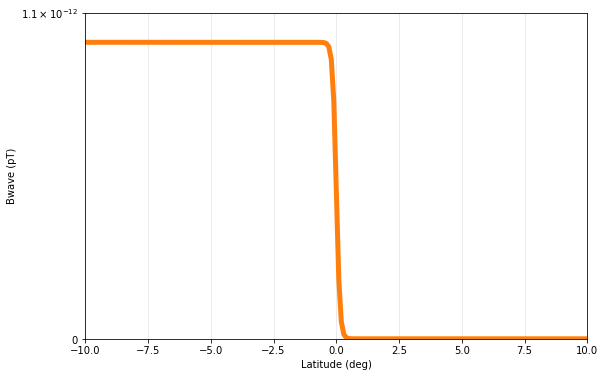

In [8]:
#define the wave packet latitudinal range
lamda_packet2=np.arange(-10,10,0.1)
lamda_packet_rad2=np.deg2rad(lamda_packet2)

#define the y-component of the wave magnetic field
Byw0_packet2=1*10**(-12)

#WPIT.WaveProperties_mod.wave_packet_one_sided parameters
shape=7
direction='south'
location=0

#allocation
Bw_packet2=[]

#calculate the wave amplitude for the defined latitudinal range
for i in range(0,len(lamda_packet2)):

    Bytmp=wave.wave_packet_one_sided(Byw0_packet2,lamda_packet_rad2[i],shape,location,direction)
    Bw_packet2.append(Bytmp)


#Plot the wave packet    
fig, ax = plt.subplots(figsize=(9,6))
s=5
ax.plot(lamda_packet2,Bw_packet2,c='tab:orange',linewidth=s)
ax.grid(alpha=.3)
ax.set_xlim(-10,10)
ax.set_yscale('symlog')
ax.set_xlabel('Latitude (deg)')
ax.set_ylabel('Bwave (pT)')

ax.set_ylim(0,1.1*10**(-12))
# ticks=np.arange(0,2*np.pi,1)
# cbar=fig.colorbar(cmap, ticks=ticks)
# cbar.set_label('gyro-phase (rad)', rotation=270,labelpad=15)
#     ax.axvline(x=-5,color="black", linestyle="--")
plt.show()


### 7. Runge-Kutta

In [9]:
starttime = time.time() #start real time of the simulation, used to calculate the computational time

for k in range(0,len(eta0)):
    
    #initialize the parameters
    i=0
    timef[k,0]=0
    pper[k,0]=pper0
    ppar[k,0]=ppar0
    eta[k,0]=eta0[k]
    lamda[k,0]=lamda0
    zeta[k,0]=0
    upar[k,0]=upar0
    uper[k,0]=uper0
    alpha[k,0]=alpha0
    alpha2[k,0]=alpha0
    aeq[k,0]=aeq0
    aeq2[k,0]=aeq0
    mu_out[k,0]=mu0
    deta_dt[k,0]=0
    S_stix[k,0]=S0
    D_stix[k,0]=D0
    P_stix[k,0]=P0
    R_stix[k,0]=R0
    L_stix[k,0]=L0
    kappa_out[k,0]=kappa0
    kx_out[k,0]=kappax0
    kz_out[k,0]=kappaz0
    dwh_dt_out[k,0]=dwceds0
    gamma_out[k,0]=gamma0
    E_kin[k,0]=1.602176487E-16*Ekev0 #from keV to ergs
    v_res_out[k,0]=v_para_res0
    E_res_out[k,0]=E_res0
    Bxw_out[k,0]=Bxw0
    Byw_out[k,0]=Byw0
    Bzw_out[k,0]=Bzw0
    Exw_out[k,0]=Exw0
    Eyw_out[k,0]=Eyw0
    Ezw_out[k,0]=Ezw0
    wce_out[k,0]=wce0
    wcH_out[k,0]=wcH0
    wcHe_out[k,0]=wcHe0
    wcO_out[k,0]=wcO0
    wpe_out[k,0]=wpe0
    wpHe_out[k,0]=wpHe0
    wpH_out[k,0]=wpH0
    wpO_out[k,0]=wpO0
    wlhr_out[k,0]=wlhr0
    wuhr_out[k,0]=wuhr0

    ne_out[k,0]=ne0
    nH_out[k,0]=nH0
    nHe_out[k,0]=nHe0
    nO_out[k,0]=nO0
    dwceds_out[k,0]=dwceds0
    dwcHds_out[k,0]=dwcHds0
    dwcHeds_out[k,0]=dwcHeds0
    dwcOds_out[k,0]=dwcOds0
    Bmag_out[k,0]=Bmag0

    while i<Nsteps:
    ######################################################################################################
    #First step of Runge Kutta
    ######################################################################################################

        #calculate the magnetic field strength
        Bmag=env.Bmag_dipole(L_shell,lamda[k,i])
        
        #calculate the electron density
        ne=env.density_FL_denton(ne_0,lamda[k,i])

        #Ion composition assuming 88%H+, 10%He+, 2%O+
        nH=0.88*ne
        nHe=0.1*ne
        nO=0.02*ne    
 
        #calculate the Stix parameters
        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)

        #calculate the refractive index and the wave numbers
        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)

        #calculate the electron cyclotron frequency
        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)
        
        #calculate the y-component of the wave magnetic field
        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i],shape,location,direction)

        #calculate the amplitudes of the wave magnetic and electric field components
        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        
        #calculate the gradient of the electron gyrofrequency
        dwceds=env.dwc_ds(wce,lamda[k,i],L_shell)

        #calculate the wpi parameters
        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i],pper[k,i],Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        
        #calculate resonant velocities, resonant energy and resonant lorentz factor
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i],env.const.me)
        
        #calculate the Runge-Kutta coeeficients for each differential equation
        k1=wpi.dzdt(ppar[k,i],gamma,env.const.me)
        l1=wpi.dppardt(pper[k,i],eta[k,i],wtau_sq,kz,gamma,wce,dwceds)
        m1=wpi.dpperdt(ppar[k,i],pper[k,i],eta[k,i],w1,w2,beta,gamma,R1,R2,m_res,wce,dwceds)
        n1=wpi.detadt(ppar[k,i],m_res,wce,w_wave,gamma,kz)
        o1=wpi.dlamdadt(ppar[k,i],lamda[k,i],gamma,L_shell)
        p1=wpi.dalphadt(pper[k,i],ppar[k,i],eta[k,i],w1,w2,R1,R2,wtau_sq,kz,beta,m_res,gamma,wce,dwceds)
        q1=wpi.daeqdt(ppar[k,i],pper[k,i],alpha[k,i],aeq[k,i],eta[k,i],w1,R1,w2,R2,gamma,beta,wtau_sq,kz,m_res)
        r1=wpi.dgammadt(pper[k,i],ppar[k,i],eta[k,i],m_res,Exw,Eyw,Ezw,beta,gamma)
        s1=wpi.dEkdt(pper[k,i],ppar[k,i],eta[k,i],m_res,Exw,Eyw,Ezw,beta,gamma)
        

#     ######################################################################################################
#     #Second step of Runge Kutta
#     ######################################################################################################

        #calculate the magnetic field strength
        Bmag=env.Bmag_dipole(L_shell,lamda[k,i]+0.5*h*o1)
        
        #calculate the electron density
        ne=env.density_FL_denton(ne_0,lamda[k,i]+0.5*h*o1)

        #Ion composition assuming 88%H+, 10%He+, 2%O+
        nH=0.88*ne
        nHe=0.1*ne
        nO=0.02*ne    
        
        #calculate the Stix parameters
        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)

        #calculate the refractive index and the wave numbers
        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)

        #calculate the electron cyclotron frequency
        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)
        
        #calculate the y-component of the wave magnetic field
        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i]+0.5*h*o1,shape,location,direction)

        #calculate the amplitudes of the wave magnetic and electric field components
        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        
        #calculate the gradient of the electron gyrofrequency
        dwceds=env.dwc_ds(wce,lamda[k,i]+0.5*h*o1,L_shell)

        #calculate the wpi parameters
        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i]+0.5*h*l1,pper[k,i]+0.5*h*m1,Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        
        #calculate resonant velocities, resonant energy and resonant lorentz factor
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i]+0.5*h*p1,env.const.me)
        
        #calculate the Runge-Kutta coeeficients for each differential equation
        k2=wpi.dzdt(ppar[k,i]+0.5*h*l1,gamma,env.const.me)
        l2=wpi.dppardt(pper[k,i]+0.5*h*m1,eta[k,i]+0.5*h*n1,wtau_sq,kz,gamma,wce,dwceds)
        m2=wpi.dpperdt(ppar[k,i]+0.5*h*l1,pper[k,i]+0.5*h*m1,eta[k,i]+0.5*h*n1,w1,w2,beta,gamma,R1,R2,m_res,wce,dwceds)
        n2=wpi.detadt(ppar[k,i]+0.5*h*l1,m_res,wce,w_wave,gamma,kz)
        o2=wpi.dlamdadt(ppar[k,i]+0.5*h*l1,lamda[k,i]+0.5*h*o1,gamma,L_shell)
        p2=wpi.dalphadt(pper[k,i]+0.5*h*m1,ppar[k,i]+0.5*h*l1,eta[k,i]+0.5*h*n1,w1,w2,R1,R2,wtau_sq,kz,beta,m_res,gamma,wce,dwceds)
        q2=wpi.daeqdt(ppar[k,i]+0.5*h*l1,pper[k,i]+0.5*h*m1,alpha[k,i]+0.5*h*p1,aeq[k,i]+0.5*h*q1,eta[k,i]+0.5*h*n1,w1,R1,w2,R2,gamma,beta,wtau_sq,kz,m_res)
        r2=wpi.dgammadt(pper[k,i]+0.5*h*m1,ppar[k,i]+0.5*h*l1,eta[k,i]+0.5*h*n1,m_res,Exw,Eyw,Ezw,beta,gamma)
        s2=wpi.dEkdt(pper[k,i]+0.5*h*m1,ppar[k,i]+0.5*h*l1,eta[k,i]+0.5*h*n1,m_res,Exw,Eyw,Ezw,beta,gamma)
        
#     ######################################################################################################
#     #Third step of Runge Kutta
#     ######################################################################################################

        #calculate the magnetic field strength
        Bmag=env.Bmag_dipole(L_shell,lamda[k,i]+0.5*h*o2)
        
        #calculate the electron density
        ne=env.density_FL_denton(ne_0,lamda[k,i]+0.5*h*o2)

        #Ion composition assuming 88%H+, 10%He+, 2%O+
        nH=0.88*ne
        nHe=0.1*ne
        nO=0.02*ne    

        #calculate the Stix parameters
        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)

        #calculate the refractive index and the wave numbers
        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)

        #calculate the electron cyclotron frequency
        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)

        #calculate the y-component of the wave magnetic field
        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i]+0.5*h*o2,shape,location,direction)
        
        #calculate the amplitudes of the wave magnetic and electric field components
        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        
        #calculate the gradient of the electron gyrofrequency
        dwceds=env.dwc_ds(wce,lamda[k,i]+0.5*h*o2,L_shell)

        #calculate the wpi parameters
        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i]+0.5*h*l2,pper[k,i]+0.5*h*m2,Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        
        #calculate resonant velocities, resonant energy and resonant lorentz factor
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i]+0.5*h*p2,env.const.me)
        
        #calculate the Runge-Kutta coeeficients for each differential equation
        k3=wpi.dzdt(ppar[k,i]+0.5*h*l2,gamma,env.const.me)
        l3=wpi.dppardt(pper[k,i]+0.5*h*m2,eta[k,i]+0.5*h*n2,wtau_sq,kz,gamma,wce,dwceds)
        m3=wpi.dpperdt(ppar[k,i]+0.5*h*l2,pper[k,i]+0.5*h*m2,eta[k,i]+0.5*h*n2,w1,w2,beta,gamma,R1,R2,m_res,wce,dwceds)
        n3=wpi.detadt(ppar[k,i]+0.5*h*l2,m_res,wce,w_wave,gamma,kz)
        o3=wpi.dlamdadt(ppar[k,i]+0.5*h*l2,lamda[k,i]+0.5*h*o2,gamma,L_shell)
        p3=wpi.dalphadt(pper[k,i]+0.5*h*m2,ppar[k,i]+0.5*h*l2,eta[k,i]+0.5*h*n2,w1,w2,R1,R2,wtau_sq,kz,beta,m_res,gamma,wce,dwceds)
        q3=wpi.daeqdt(ppar[k,i]+0.5*h*l2,pper[k,i]+0.5*h*m2,alpha[k,i]+0.5*h*p2,aeq[k,i]+0.5*h*q2,eta[k,i]+0.5*h*n2,w1,R1,w2,R2,gamma,beta,wtau_sq,kz,m_res)
        r3=wpi.dgammadt(pper[k,i]+0.5*h*m2,ppar[k,i]+0.5*h*l2,eta[k,i]+0.5*h*n2,m_res,Exw,Eyw,Ezw,beta,gamma)
        s3=wpi.dEkdt(pper[k,i]+0.5*h*m2,ppar[k,i]+0.5*h*l2,eta[k,i]+0.5*h*n2,m_res,Exw,Eyw,Ezw,beta,gamma)
#     ######################################################################################################
#     #Fourth step of Runge Kutta
#     ######################################################################################################

        #calculate the magnetic field strength
        Bmag=env.Bmag_dipole(L_shell,lamda[k,i]+h*o3)
        
        #calculate the electron density
        ne=env.density_FL_denton(ne_0,lamda[k,i]+h*o3)

        #Ion composition assuming 88%H+, 10%He+, 2%O+
        nH=0.88*ne
        nHe=0.1*ne
        nO=0.02*ne       

        #calculate the Stix parameters
        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)

        #calculate the refractive index and the wave numbers
        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)

        #calculate the electron cyclotron frequency
        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)

        #calculate the y-component of the wave magnetic field
        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i]+h*o3,shape,location,direction)
        
        #calculate the amplitudes of the wave magnetic and electric field components
        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        
        #calculate the gradient of the electron gyrofrequency
        dwceds=env.dwc_ds(wce,lamda[k,i]+h*o3,L_shell)

        #calculate the wpi parameters
        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i]+h*l3,pper[k,i]+h*m3,Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        
        #calculate resonant velocities, resonant energy and resonant lorentz factor
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i]+h*p3,env.const.me)
        
        #calculate the Runge-Kutta coeeficients for each differential equation
        k4=wpi.dzdt(ppar[k,i]+h*l3,gamma,env.const.me)
        l4=wpi.dppardt(pper[k,i]+h*m3,eta[k,i]+h*n3,wtau_sq,kz,gamma,wce,dwceds)
        m4=wpi.dpperdt(ppar[k,i]+h*l3,pper[k,i]+h*m3,eta[k,i]+h*n3,w1,w2,beta,gamma,R1,R2,m_res,wce,dwceds)
        n4=wpi.detadt(ppar[k,i]+h*l3,m_res,wce,w_wave,gamma,kz)
        o4=wpi.dlamdadt(ppar[k,i]+h*l3,lamda[k,i]+h*o3,gamma,L_shell)
        p4=wpi.dalphadt(pper[k,i]+h*m3,ppar[k,i]+h*l3,eta[k,i]+h*n3,w1,w2,R1,R2,wtau_sq,kz,beta,m_res,gamma,wce,dwceds)
        q4=wpi.daeqdt(ppar[k,i]+h*l3,pper[k,i]+h*m3,alpha[k,i]+h*p3,aeq[k,i]+h*q3,eta[k,i]+h*n3,w1,R1,w2,R2,gamma,beta,wtau_sq,kz,m_res)
        r4=wpi.dgammadt(pper[k,i]+h*m3,ppar[k,i]+h*l3,eta[k,i]+h*n3,m_res,Exw,Eyw,Ezw,beta,gamma)
        s4=wpi.dEkdt(pper[k,i]+h*m3,ppar[k,i]+h*l3,eta[k,i]+h*n3,m_res,Exw,Eyw,Ezw,beta,gamma)
        
#    ####################################################################################################
#    #calculate the final parameters
#    ####################################################################################################
        
        #distance along the field line
        zeta[k,i+1]=zeta[k,i]+(h/6)*(k1+2*k2+2*k3+k4)
        
        #parallel to the magnetic field component of momentum
        ppar[k,i+1]=ppar[k,i]+(h/6)*(l1+2*l2+2*l3+l4)
        
        #perpendicular to the magnetic field component of momentum
        pper[k,i+1]=pper[k,i]+(h/6)*(m1+2*m2+2*m3+m4)
        
        #wave-electron phase
        eta[k,i+1]=(eta[k,i]+(h/6)*(n1+2*n2+2*n3+n4))
        
        #magnetic latitude
        lamda[k,i+1]=lamda[k,i]+(h/6)*(o1+2*o2+2*o3+o4)
        
        #local pitch angle
        alpha[k,i+1]=alpha[k,i]+(h/6)*(p1+2*p2+2*p3+p4)
        
        #equatorial pitch angle
        aeq[k,i+1]=aeq[k,i]+(h/6)*(q1+2*q2+2*q3+q4)
        
        #time evolution of wave-electron phase
        deta_dt[k,i+1]=(1/6)*(n1+2*n2+2*n3+n4)
        
        #Lorentz factor
        gamma_out[k,i+1]=gamma_out[k,i]+(h/6)*(r1+2*r2+2*r3+r4)
        
        #Kinetic energy
        E_kin[k,i+1]=E_kin[k,i]+(h/6)*(s1+2*s2+2*s3+s4)

        #parallel to the magnetic field component of velocity
        upar[k,i+1]=ppar[k,i+1]/(env.const.me*gamma)
        
        #perpendicular to the magnetic field component of velocity
        uper[k,i+1]=pper[k,i+1]/(env.const.me*gamma)
        
        #velocity magnitude
        u_mag=np.sqrt(upar[k,i+1]+uper[k,i+1]**2)

#    ######################################################################################################
#    Calculate parameters at final step
#    ######################################################################################################

        #calculate the magnetic field strength
        Bmag=env.Bmag_dipole(L_shell,lamda[k,i+1])
        
        #calculate the electron density
        ne=env.density_FL_denton(ne_0,lamda[k,i+1])
        
        #Ion composition assuming 88%H+, 10%He+, 2%O+
        nH=0.88*ne
        nHe=0.1*ne
        nO=0.02*ne   
        
        #calculate the Stix parameters
        S,D,P,R,L=wave.stix_parameters(w_wave, ne, nH, nHe, nO, Bmag)
        
        #calculate the refractive index and the wave numbers
        eta_sq_plus,eta_sq_minus,mu,kappa,kz,kx=wave.refr_index_full(theta0,w_wave,S,P,R,L)
        
        #calculate the electron cyclotron frequency
        wce=env.omega_cyclotron(Bmag,env.const.qe,env.const.me)
        
        #calculate the y-component of the wave magnetic field
        By_packet=wave.wave_packet_one_sided(By_wave,lamda[k,i+1],shape,location,direction)
        
        #calculate the amplitudes of the wave magnetic and electric field components
        Bxw, Byw, Bzw, Exw, Eyw, Ezw=wave.wave_amplitudes_bell(mu,P,D,S,By_packet,theta0)
        
        #calculate the gradient of the electron gyrofrequency
        dwceds=env.dwc_ds(wce,lamda[k,i+1],L_shell)
        
        #calculate the wpi parameters
        gamma,w1,w2,wtau_sq,R1,R2,beta=wpi.wpi_params(m_res,ppar[k,i+1],pper[k,i+1],Bxw, Byw,Exw,Eyw,Ezw,kz,kx,wce)
        
        #calculate resonant velocities, resonant energy and resonant lorentz factor
        v_para_res, v_per_res, v_tot_res, E_res,gamma_res=wave.resonant_velocity(m_res,w_wave,kz,wce,alpha[k,i+1],env.const.me)
        
        #caclualte gyrofrequencies
        wcHf=env.omega_cyclotron(Bmag,env.const.qe,env.const.mH)
        wcHef=env.omega_cyclotron(Bmag,env.const.qe,env.const.mHe)
        wcOf=env.omega_cyclotron(Bmag,env.const.qe,env.const.mO)
        
        #calulate plasma frequencies
        wpef=env.omega_plasma(ne,env.const.qe,env.const.me)
        wpHf=env.omega_plasma(nH,env.const.qi,env.const.mH)
        wpHef=env.omega_plasma(nHe,env.const.qi,env.const.mHe)
        wpOf=env.omega_plasma(nO,env.const.qi,env.const.mO)
        wuhrf=env.omega_uhr(wce,wpef)
        wlhrf=env.omega_lhr(wce, wpef, wcHf, wpHf)
        
        #calculate gradients of the gyro frequencies
        dwcHds=env.dwc_ds(wcHf,lamda[k,i+1],L_shell)
        dwcHeds=env.dwc_ds(wcHef,lamda[k,i+1],L_shell)
        dwcOds=env.dwc_ds(wcOf,lamda[k,i+1],L_shell)
        

        #Output the results
        wce_out[k,i+1]=wce
        wcH_out[k,i+1]=wcHf
        wcHe_out[k,i+1]=wcHef
        wcO_out[k,i+1]=wcOf
        wpe_out[k,i+1]=wpef
        wpHe_out[k,i+1]=wpHef
        wpH_out[k,i+1]=wpHf
        wpO_out[k,i+1]=wpOf
        wlhr_out[k,i+1]=wlhrf
        wuhr_out[k,i+1]=wuhrf
        dwceds_out[k,i+1]=dwceds   
        dwcHds_out[k,i+1]=dwcHds 
        dwcHeds_out[k,i+1]=dwcHeds 
        dwcOds_out[k,i+1]=dwcOds 
        ne_out[k,i+1]=ne
        nH_out[k,i+1]=nH
        nHe_out[k,i+1]=nHe
        nO_out[k,i+1]=nO
        mu_out[k,i+1]=mu
        S_stix[k,i+1]=S
        D_stix[k,i+1]=D
        P_stix[k,i+1]=P
        R_stix[k,i+1]=R
        L_stix[k,i+1]=L
        kx_out[k,i+1]=kx
        kz_out[k,i+1]=kz
        dwh_dt_out[k,i+1]=dwceds
        kappa_out[k,i+1]=kappa
        Bxw_out[k,i+1]=Bxw
        Byw_out[k,i+1]=Byw
        Bzw_out[k,i+1]=Bzw
        Exw_out[k,i+1]=Exw
        Eyw_out[k,i+1]=Eyw
        Ezw_out[k,i+1]=Ezw
        Bmag_out[k,i+1]=Bmag

        v_res_out[k,i+1]=v_para_res
        E_res_out[k,i+1]=E_res
        
#    #################################################################################################
#    Investigation of nonlinear effects 
#    ################################################################################################## 

        
        C0_rk=wpi.nonlinear_C0(ppar[k,i+1],m_res,wce,kz,gamma,Ezw)
        C1p_rk=wpi.nonlinear_C1p(pper[k,i+1],ppar[k,i+1],w2,Exw,Eyw,m_res,wce,kz,gamma)
        C1m_rk=wpi.nonlinear_C1m(pper[k,i+1],ppar[k,i+1],w1,Exw,Eyw,m_res,wce,kz,gamma)
        
        th_rk,wtr_rk=wpi.nonlinear_theta(C0_rk,C1p_rk,C1m_rk,m_res,beta)
        
        dkpar_dt=(kappa_out[k,i]-kappa_out[k,i-1])/h

        H_rk=wpi.nonlinear_H(pper[k,i+1],ppar[k,i+1],kz,gamma,m_res,env.const.me,wce,dkpar_dt,dwceds,0)
        
        #calculate the S parameter
        S_rk=wpi.nonlinear_S(H_rk,wtr_rk)
        
        #Output the results
        S_out[k,i+1]=S_rk
        wtrsq_out[k,i+1]=wtr_rk
        C0_out[k,i+1]=C0_rk
        C1p_out[k,i+1]=C1p_rk
        C1m_out[k,i+1]=C1m_rk

#    ##################################################################################################
        
        #calculate simulation time
        i=i+1
        timef[k,i]=timef[k,i-1]+h

stoptime = time.time() #stop time of the simulation, used to calculate the computational time
print('done')
print ("Finished with wpi interactions")
print ("Time elapsed: %f seconds"%(stoptime - starttime)) #computational time

/home/tourgaidis/Επιφάνεια εργασίας/WPIT_GIT_Review/WPIT/WPIT/WPI_mod/whistler_electron_mod/wpi_params.py:14: RuntimeWarning: invalid value encountered in double_scalars
  a1_arg=w2_arg/w1_arg   #Borntik thesis 2.25f
/home/tourgaidis/Επιφάνεια εργασίας/WPIT_GIT_Review/WPIT/WPIT/WPI_mod/whistler_electron_mod/wpi_params.py:15: RuntimeWarning: invalid value encountered in double_scalars
  a2_arg=(const.qe*Ezw_arg)/(w1_arg*pper_arg)   #Borntik thesis 2.25g
/home/tourgaidis/Επιφάνεια εργασίας/WPIT_GIT_Review/WPIT/WPIT/WPI_mod/whistler_electron_mod/wpi_params.py:16: RuntimeWarning: invalid value encountered in double_scalars
  R1_arg=(Exw_arg+Eyw_arg)/(Bxw_arg+Byw_arg)   #Borntik thesis 2.25h
/home/tourgaidis/Επιφάνεια εργασίας/WPIT_GIT_Review/WPIT/WPIT/WPI_mod/whistler_electron_mod/wpi_params.py:17: RuntimeWarning: invalid value encountered in double_scalars
  R2_arg=(Exw_arg-Eyw_arg)/(Bxw_arg-Byw_arg)   #Borntik thesis 2.25h


done
Finished with wpi interactions
Time elapsed: 903.452125 seconds


# 8. Plots of the results

### 8.1 Define colormaps for ploting

In [10]:
from matplotlib import cm
import matplotlib.font_manager
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
import matplotlib.ticker as tck
inch_to_mm=0.0393700787

aeq=np.nan_to_num(aeq)
dalpha=[]
for r in range(0,len(eta0)):
    ls=np.max(np.nonzero(aeq[r,:]))
    dalphaf=np.rad2deg(aeq[r,ls])-aeq0_deg
    dalpha.append(dalphaf)
#     print(np.rad2deg(aeq[r,ls]))

norm = cm.colors.Normalize(vmin=eta0.min(), vmax=eta0.max())
cmap = cm.ScalarMappable(norm=norm, cmap=cm.jet)
cmap.set_array([])

norm2 = cm.colors.Normalize(vmin=eta0.min(), vmax=eta0.max())
cmap2 = cm.ScalarMappable(norm=norm2, cmap=cm.winter)
cmap2.set_array([])

### 8.2 Multiplot of evolution of αeq along λ, distribution of ∆αeq with respect to the initial wave-particle phase η0, derivative of wave-particle phase η along λ and electron trajectories in the ν-η plane.

/home/tourgaidis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


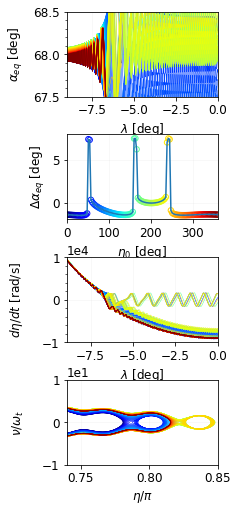

In [11]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})

wtr=np.sqrt(wtrsq_out)
last=770
nplot=deta_dt/wtr

fig, axs = plt.subplots(4,1,figsize=(3,7))

# fig.suptitle('$B_y^w$=10pT')

plt.tight_layout()
for r in range(0,len(eta0)):
    axs[0].plot(np.rad2deg(lamda[r,:-1]),np.rad2deg(aeq[r,:-1]),c=cmap.to_rgba(eta0[r]),linewidth=0.5)
axs[0].grid(alpha=.1)
axs[0].set_xlim(-9,0)
axs[0].set_xlabel(r'$\lambda$ [deg]')
axs[0].set_ylabel(r'$\alpha_{eq}$ [deg]',labelpad=8)
# axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[0].yaxis.set_minor_locator(tck.AutoMinorLocator())
axs[0].set_ylim(67.5,68.5)

axs[1].plot(np.rad2deg(eta0),dalpha)
axs[1].scatter(np.rad2deg(eta0),dalpha,marker='o',facecolors='none', edgecolors=cmap.to_rgba(eta0[:]),s=30)
axs[1].grid(alpha=.1)
# axs[1].set_ylim(-3.5,11)
axs[1].set_xlim(0,360)
axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

axs[1].set_xlabel(r'$\eta_0$ [deg]')
axs[1].set_ylabel(r'$\Delta\alpha_{eq}$ [deg]',labelpad=5)

for r in range(0,len(eta0)):
    axs[2].plot(np.rad2deg(lamda[r,:-1]),deta_dt[r,:-1],c=cmap.to_rgba(eta0[r]),linewidth=0.5)
    
axs[2].grid(alpha=.1)
axs[2].set_xlim(-8.9,0)
axs[2].set_ylim(-1*10**(4),1*10**(4))


axs[2].set_xlabel(r'$\lambda$ [deg]')
axs[2].set_ylabel(r'$d\eta/dt$ [rad/s]',labelpad=17)
axs[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[2].yaxis.set_minor_locator(tck.AutoMinorLocator())

for r in range(0,len(eta0)):
    axs[3].plot(eta[r,:-1700]/180,nplot[r,:-1700],c=cmap.to_rgba(eta0[r]),linewidth=0.5)
    
axs[3].grid(alpha=.1)
axs[3].set_xlim(0.74,0.85)
axs[3].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[3].set_xlabel(r'$\eta/\pi$')
axs[3].set_ylabel(r'$\nu/\omega_t$',labelpad=16)
axs[3].set_ylim(-10,10)

# plt.savefig('Multi_aeq_%.1f_By_%.1f_nT_E_%1.f_psi_%.1f_neq_%.1f.jpg' %(aeq0_deg,By_wave/10**(-12),Ekev0,theta0,ne_0),dpi=300, bbox_inches="tight")
plt.show()



### 8.3 Large figure for phase trapping and phase bunching indications

/home/tourgaidis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/home/tourgaidis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in remainder


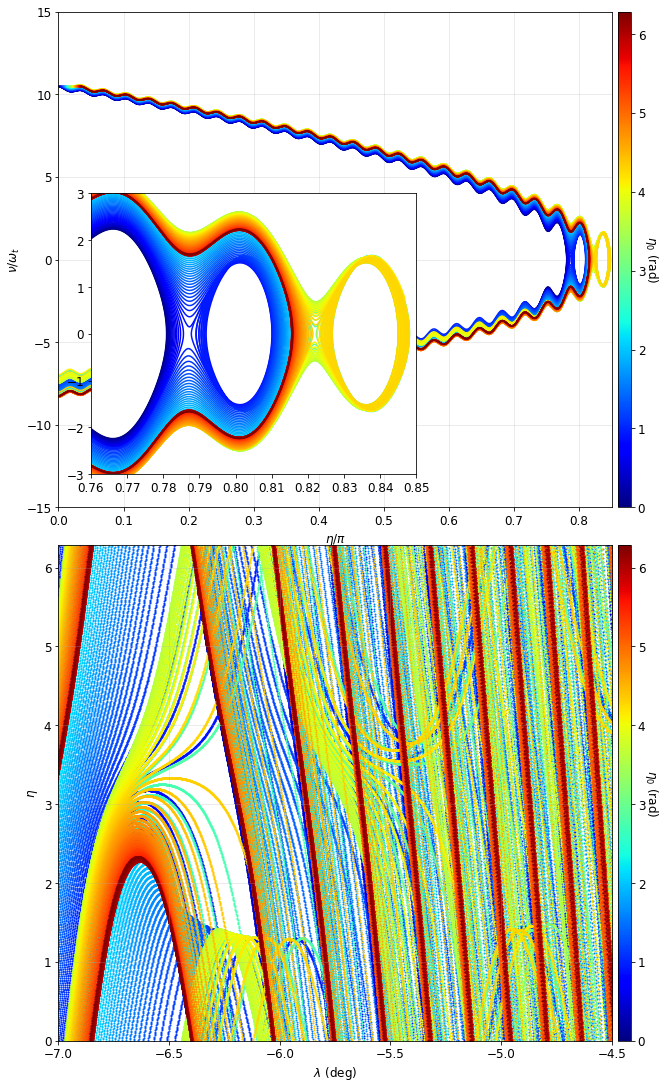

In [12]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})

wtr=np.sqrt(wtrsq_out)
last=1200
nplot=deta_dt/wtr
fonts=12 
fig, axs = plt.subplots(2,1,figsize=(10,15))

plt.tight_layout()

for r in range(0,len(eta0)):
    axs[0].plot(eta[r,:-last]/180,nplot[r,:-last],c=cmap.to_rgba(eta0[r]))

axs[0].grid(alpha=.3)
axs[0].set_xlim(0,0.85)
axs[0].set_ylim(-15,15)
axs[0].set_xlabel(r'$\eta/\pi$',fontsize=fonts)
axs[0].set_ylabel(r'$\nu/\omega_t$ ',fontsize=fonts)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

axins = axs[0].inset_axes([0.05, -13, 0.5, 17],transform=axs[0].transData)

for r in range(0,len(eta0)):
    axins.plot(eta[r,:-last]/180,nplot[r,:-last],c=cmap.to_rgba(eta0[r]))
    
axins.set_xlim(0.76, 0.85)
axins.set_ylim(-3, 3)
# axins.tick_params(axis='both', which='major', labelsize=6)
# mark_inset(axs[0], axins, loc1=4, loc2=1, fc="gray",alpha=.2, ec="0.1")
cbar=fig.colorbar(cmap,aspect=40,pad=0.01,ax=axs[0])
cbar.set_label(r'$\eta_0$ (rad)', rotation=270,labelpad=15,fontsize=fonts)
# axs[0].set_title('Electron trajectories in the ν-η plane',fontsize=12)


for r in range(0,len(eta0)):
    axs[1].scatter(np.rad2deg(lamda[r,:-1]),eta[r,:-1]%(2*np.pi),c=cmap.to_rgba(eta0[r]),s=1)

axs[1].grid(alpha=.3)
axs[1].set_xlim(-7,-4.5)
axs[1].set_ylim(0,2*np.pi)

axs[1].set_xlabel(r'$\lambda$ (deg)',fontsize=fonts)
axs[1].set_ylabel(r'$\eta$',fontsize=fonts)
# axs[1].set_title('Wave-ion phase ',fontsize=fonts)

# cbar=fig.colorbar(cmap, ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi])
# cbar.ax.set_yticklabels([r'$-\pi$',r'$-\pi/2$', '0',r'$\pi/2$', r'$-\pi$'])  # horizontal colorbar
cbar=fig.colorbar(cmap,aspect=40,pad=0.01,ax=axs[1])
cbar.set_label(r'$\eta_0$ (rad)', rotation=270,labelpad=15,fontsize=fonts)


plt.savefig('100pT.jpg' , dpi=300, bbox_inches="tight")
plt.show()


